In [8]:
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import numpy as np

import functions as f
%load_ext autoreload
%autoreload 2

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dask 

### local

In [4]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33305,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.81 GiB
Comm: tcp://127.0.0.1:35743,Total threads: 4
Dashboard: http://127.0.0.1:45839/status,Memory: 15.70 GiB
Nanny: tcp://127.0.0.1:45857,


### with gateway

In [2]:
from dask.distributed import Client
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
cluster = gateway.new_cluster(worker_memory=2, worker_cores=1)
cluster.scale(8)
client = Client(cluster) # create a dask Gateway cluster
cluster

In [4]:
if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.3ab9517d935644eab53f2f939526b404/status,


In [4]:
# closing open zombies
# clusters=gateway.list_clusters()
# print(clusters )
# for cluster in clusters :
#     cluster= gateway.connect(cluster.name)
#     print(cluster)
#     client = Client(cluster)
#     client.close()
#     cluster.shutdown()

### closing

In [3]:
# To close at end of session
client.close()

In [ ]:
cluster.shutdown()

## DMS Data

In [9]:
s3.ls('escience2022/Antoine/Satellite_Arctic_DMS')

['escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2003_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2004_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2005_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2006_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2007_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2008_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2009_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2011_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2012_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2013_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2014_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2015_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2016_8D_28km.nc',
 'esci

## Open files

In [2]:
#### single file
# file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc'
# file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_S2004_8D_28km.nc'
# ds = xr.open_dataset(s3.open(file)).squeeze()

### multiple files
s3files = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A*_8D_28km.nc'
remote_files = s3.glob(s3files)
fileset = [s3.open(file) for file in remote_files]
ds = xr.open_mfdataset(fileset, combine='by_coords')
## remove dependence of lat and long on year
ds['latitude'] = ds.latitude.isel(year=0)
ds['longitude'] = ds.longitude.isel(year=0)
# ds

In [3]:
## add date
import datetime
dates = np.array([
    [datetime.datetime(int(y.values), 1, 1) + datetime.timedelta(d.values - 1) for d in ds.startjulday.sel(year=y)] 
        for y in ds.year])

ds=ds.assign_coords({ "d": (['year','period'],dates ) })
ds=ds.stack(time=['year','period'])
ds=ds.set_index(time='d')
ds

<xarray.Dataset>
Dimensions:      (pixel: 96668, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel) float64 dask.array<chunksize=(96668,), meta=np.ndarray>
    latitude     (pixel) float64 dask.array<chunksize=(96668,), meta=np.ndarray>
    startjulday  (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    endjulday    (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    dms          (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>

## Selecting area

### with lat / long

In [4]:
ds = ds.where(
    (ds.longitude>=-10) & (ds.longitude<=10) & 
    (ds.latitude <=85 ) & (ds.latitude >= 70),
    drop = True)
ds

<xarray.Dataset>
Dimensions:      (pixel: 1033, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel) float64 dask.array<chunksize=(1033,), meta=np.ndarray>
    latitude     (pixel) float64 dask.array<chunksize=(1033,), meta=np.ndarray>
    startjulday  (time, pixel) float64 dask.array<chunksize=(46, 1033), meta=np.ndarray>
    endjulday    (time, pixel) float64 dask.array<chunksize=(46, 1033), meta=np.ndarray>
    dms          (pixel, time) float64 dask.array<chunksize=(1033, 46), meta=np.ndarray>

### with masks

In [4]:
dmsk= xr.open_dataset('cordexMaskGali19.nc')
dmsk

<xarray.Dataset>
Dimensions:    (pixel: 96668)
Coordinates:
    latitude   (pixel) float64 ...
    longitude  (pixel) float64 ...
Dimensions without coordinates: pixel
Data variables:
    mask       (pixel) float64 ...

In [7]:
Norsea=14
ds=ds.where(dmsk.mask==Norsea,drop=True)
# sib=10
# ds=ds.where(dmsk.mask==sib)
ds

<xarray.Dataset>
Dimensions:      (time: 644, pixel: 2308)
Coordinates:
    longitude    (pixel) float64 -13.37 -12.77 -12.18 -11.58 ... 9.96 8.745 10.2
    latitude     (pixel) float64 65.12 65.12 65.12 65.12 ... 79.88 80.12 80.12
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    startjulday  (time, pixel) float64 dask.array<chunksize=(46, 2308), meta=np.ndarray>
    endjulday    (time, pixel) float64 dask.array<chunksize=(46, 2308), meta=np.ndarray>
    dms          (pixel, time) float64 dask.array<chunksize=(2308, 46), meta=np.ndarray>

#### plot to check selected area

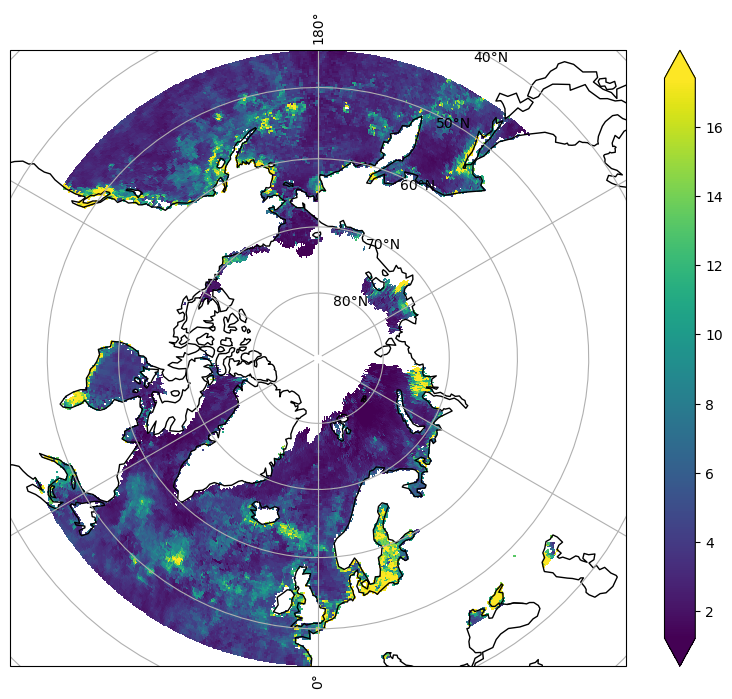

In [4]:
import functions as f

dms_gridded = f.interGali(ds.sel(time='2013-07-20'), 'dms')
fig, ax = plt.subplots(figsize=(8,8),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
dms_gridded.plot.pcolormesh( 
        ax = ax,
        cbar_kwargs={ 'orientation':'vertical', 'shrink':.8},
        transform=ccrs.PlateCarree(),
        robust=True
    )
# ax.set_extent( [-30,30, 60,90], ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()    

## Average

In [5]:
avDMS = ds.dms.mean(dim=['pixel'])

with ProgressBar():
    avDMS = avDMS.compute()

[########################################] | 100% Completed | 84.78 s


In [6]:
doy = np.unique(ds.period.values)*8
ys =  np.unique(ds.time.year.values)
avDMS2d = avDMS.values.reshape(ys.size,doy.size).T

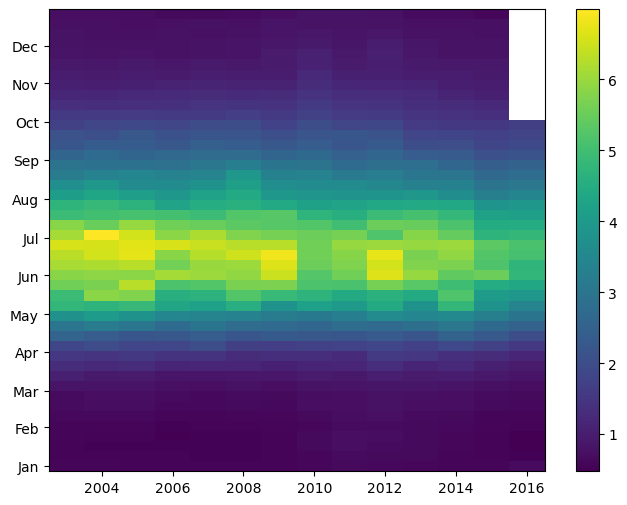

In [9]:
fig, ax = plt.subplots(figsize = (8,6))

pl=ax.pcolormesh(ys, 
            [np.datetime64('2000') + np.timedelta64(d, 'D') for d in doy], 
               avDMS2d
)
fig.colorbar(pl)


fmt = mdate.DateFormatter('%b')
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_major_locator(mdate.MonthLocator())
